# Importing  packages

In [1]:
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Importing database file

In [2]:
jobs = pd.read_csv("/Users/gsp/Documents/OS/Project/Jobs_final.csv")
jobs.set_index('JobID', inplace = True)
n_row, n_col = jobs.shape
print("Number of columns in the dataset = ", n_col)
print("Number of rows in the dataset = ", n_row)
jobs.info()
jobs.describe()
print(jobs.nunique(axis=0))

/var/folders/36/mz2dclfn2fq3fkrkpgzzh2740000gn/T/ipykernel_4959/2720614567.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  jobs = pd.read_csv("/Users/gsp/Documents/OS/Project/Jobs_final.csv")


Number of columns in the dataset =  28
Number of rows in the dataset =  1124772
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124772 entries, 1 to 1124772
Data columns (total 28 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   SubmitTime          1124772 non-null  int64  
 1   WaitTime            1124772 non-null  int64  
 2   RunTime             1124772 non-null  int64  
 3   NProc               1124772 non-null  int64  
 4   UsedCPUTime         1124772 non-null  float64
 5   UsedMemory          1124772 non-null  float64
 6   ReqNProcs           1124772 non-null  int64  
 7   ReqTime             1124772 non-null  float64
 8   ReqMemory           1124772 non-null  float64
 9   Status              1124772 non-null  int64  
 10  UserID              1124772 non-null  object 
 11  GroupID             1124772 non-null  object 
 12  ExecutableID        1124772 non-null  object 
 13  QueueID             1124772 non-null 

The columns - ReqMemory, PartitionID, UsedNetwork....Project ID have the value '-1' in all the 1124772 rows. ReqNProcs has '1' in all the 1124772 rows. They do not add any additional value to the data. So, these columns can be dropped.

In [3]:
jobs.drop(['ReqMemory', 'PartitionID', 'UsedNetwork', 'UsedLocalDiskSpace', 'UsedResources', 'ReqPlatform', 'ReqNetwork', 'ReqLocalDiskSpace', 'ReqResources', 'VOID', 'ProjectID'], axis=1, inplace=True)

In [4]:
jobs.head()

,SubmitTime,WaitTime,RunTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,Status,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,LastRunSiteID,JobStructure,JobStructureParams
JobID,,,,,,,,,,,,,,,,,
1,1109087545,9,21,1,0.05,8282.112,1,-1.0,1,U0,G0,X0,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
2,1109087546,8,21,1,0.08,10485.760,1,-1.0,1,U0,G0,X0,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
3,1109087609,5,1,1,0.00,2584.576,1,-1.0,1,U0,G0,X1,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
4,1109091229,15,0,1,0.00,0.000,1,-1.0,1,U0,G0,X1,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
5,1109091214,65162,1,1,0.00,0.000,1,-1.0,1,U0,G0,X1,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1


In [5]:
print(jobs.nunique(axis=0))

SubmitTime            826435
WaitTime               16274
RunTime                 9597
NProc                     81
UsedCPUTime            23437
UsedMemory             44118
ReqNProcs                 81
ReqTime                  255
Status                     2
UserID                   333
GroupID                   12
ExecutableID            9070
QueueID                    3
OrigSiteID                 5
LastRunSiteID              5
JobStructure               2
JobStructureParams      1958
dtype: int64


In [6]:
for col in jobs:
    lis = jobs[col].tolist()
    if -1 in lis:
        print(col)

ReqTime
JobStructureParams


The column ReqTime has -1 in a few rows. These need to be transformed to a non-negative value before doing feature selection

In [7]:
jobs['ReqTime'] = jobs['ReqTime'].replace([-1],0)

# Using only 30% of the data loaded

In [8]:
jobs = jobs.sample(frac=0.3, replace=True, random_state=1)

In [9]:
jobs.shape

(337432, 17)

# Separating features and target variable

In [10]:
X_old_1 = jobs.drop('RunTime',axis=1)
y = jobs['RunTime']

In [11]:
feature_names = list(X_old_1.columns.values)
print(feature_names)

['SubmitTime', 'WaitTime', 'NProc', 'UsedCPUTime', 'UsedMemory', 'ReqNProcs', 'ReqTime', 'Status', 'UserID', 'GroupID', 'ExecutableID', 'QueueID', 'OrigSiteID', 'LastRunSiteID', 'JobStructure', 'JobStructureParams']


# Encoding using LeaveOneOutEncoder

In [12]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_old = encoder.fit_transform(X_old_1, y)
print("X_old = ", X_old.columns)
print(X_old.head())

X_old =  Index(['SubmitTime', 'WaitTime', 'NProc', 'UsedCPUTime', 'UsedMemory',
       'ReqNProcs', 'ReqTime', 'Status', 'UserID', 'GroupID', 'ExecutableID',
       'QueueID', 'OrigSiteID', 'LastRunSiteID', 'JobStructure',
       'JobStructureParams'],
      dtype='object')
        SubmitTime  WaitTime  NProc  UsedCPUTime  UsedMemory  ReqNProcs  \
JobID                                                                     
128038  1129348952        10      2     0.015000    4782.080          2   
491756  1162636202         4      1     4.730000   32350.208          1   
470925  1161456913        14     16     0.015625    3936.256         16   
491264  1162485891         9      1     0.030000    5410.816          1   
836490  1132584628      3584      1     1.000000   64909.312          1   

        ReqTime  Status      UserID      GroupID  ExecutableID     QueueID  \
JobID                                                                        
128038    960.0       1  100.957572   302.5

# Selecting the k best features using SelectKBest and chi2

number of columns in X_old =  (337432, 16)
number of columns in X =  (337432, 10)
['SubmitTime' 'WaitTime' 'NProc' 'UsedCPUTime' 'UsedMemory' 'ReqNProcs'
 'ReqTime' 'Status' 'UserID' 'GroupID' 'ExecutableID' 'QueueID'
 'OrigSiteID' 'LastRunSiteID' 'JobStructure' 'JobStructureParams']
length of scores =  16
length of feature_names =  16
2342258461982.441 ReqTime
48898939772.2335 UsedMemory
10750993905.687475 SubmitTime
1080775535.1573536 UserID
565540486.5852001 WaitTime
476187996.51152796 ExecutableID
455637246.5525725 UsedCPUTime
16260789.988653287 JobStructureParams
8445985.871714545 GroupID
754438.5516159812 LastRunSiteID
328074.40618589276 ReqNProcs
224044.88065681586 JobStructure
109.90247044853525 QueueID
72.54875255886219 Status
[ 0  1  3  4  6  8  9 10 13 15]
['SubmitTime', 'WaitTime', 'UsedCPUTime', 'UsedMemory', 'ReqTime', 'UserID', 'GroupID', 'ExecutableID', 'LastRunSiteID', 'JobStructureParams']
CPU times: user 32.8 s, sys: 24.9 s, total: 57.7 s
Wall time: 53.5 s


<AxesSubplot:>

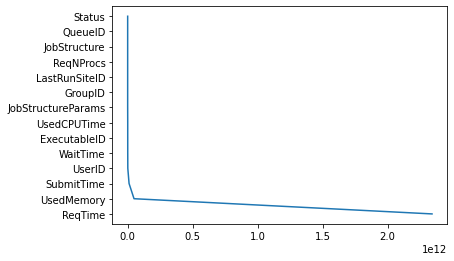

In [13]:
%%time
selector = SelectKBest(chi2, k=10).fit(X_old,y)
X = selector.transform(X_old)
print("number of columns in X_old = ", X_old.shape)
print("number of columns in X = ", X.shape)
scores = selector.scores_
print(selector.feature_names_in_)
dic = {}
i=0
print("length of scores = ", len(scores))
print("length of feature_names = ", len(feature_names))
X_v = []
Y_v = []
for score in scores:
    dic[score] = feature_names[i]
    i += 1

for key in sorted(dic, reverse=True):
    print (key, dic[key])
    X_v.append(key)
    Y_v.append(dic[key])
    
cols = selector.get_support(indices=True)
feature_names_new = [feature_names[i] for i in cols]
print(cols)
print(feature_names_new)
X_v.reverse()
Y_v.reverse()
sns.lineplot(x=X_v, y=Y_v)

# Preprocessing using minmax scaler and train_test_split

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_minmax,y, train_size = 0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, test_size=0.2, random_state=1)

# Tuned hyperparameters of LightGBM - gbdt

In [15]:
hyper_params_gbdt = {
    'metric': ['mae', 'rmse'],
    'feature_fraction': 0.9,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 1,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 2**8,  
    "max_bin": 1024,
    "num_iterations": 450
}

# Model training - Gradient Boosting Decision Tree

/Users/gsp/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 516.497	t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	training's l1: 344.195	training's rmse: 2493.76	valid_1's l1: 336.511	valid_1's rmse: 2807.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	training's l1: 341.147	training's rmse: 2470.88	valid_1's l1: 333.559	valid_1's rmse: 2784.24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	training's l1: 338.113	training's rmse: 2448.06	valid_1's l1: 330.612	valid_1's rmse: 2762.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	training's l1: 335.109	training's rmse: 2425.45	valid_1's l1: 327.699	valid_1's rmse: 2742.44
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	training's l1: 332.116	training's rmse: 2402.66	valid_1's l1: 324.835	valid_1's rmse: 2722.81
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's l1: 329.199	training's rmse: 2380.49	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l1: 214.713	training's rmse: 1543.95	valid_1's l1: 212.649	valid_1's rmse: 1972.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l1: 212.7	training's rmse: 1529.87	valid_1's l1: 210.716	valid_1's rmse: 1957.79
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	training's l1: 210.782	training's rmse: 1515.93	valid_1's l1: 208.884	valid_1's rmse: 1945.65
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's l1: 208.928	training's rmse: 1502.13	valid_1's l1: 207.107	valid_1's rmse: 1933.64
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	training's l1: 207.011	training's rmse: 1488.99	valid_1's l1: 205.283	valid_1's rmse: 1922.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	training's l1: 205.146	training's rmse: 1475.47	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	training's l1: 134.32	training's rmse: 972.194	valid_1's l1: 135.798	valid_1's rmse: 1521.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	training's l1: 133.251	training's rmse: 964.598	valid_1's l1: 134.786	valid_1's rmse: 1516.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	training's l1: 132.072	training's rmse: 956.675	valid_1's l1: 133.653	valid_1's rmse: 1511.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	training's l1: 131.02	training's rmse: 949.115	valid_1's l1: 132.662	valid_1's rmse: 1506.23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	training's l1: 129.87	training's rmse: 941.36	valid_1's l1: 131.552	valid_1's rmse: 1501.12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	training's l1: 128.729	training's rmse: 933.697	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	training's l1: 84.5536	training's rmse: 632.062	valid_1's l1: 88.401	valid_1's rmse: 1318.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	training's l1: 83.8831	training's rmse: 627.358	valid_1's l1: 87.7751	valid_1's rmse: 1315.66
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	training's l1: 83.1822	training's rmse: 621.925	valid_1's l1: 87.0854	valid_1's rmse: 1311.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	training's l1: 82.4611	training's rmse: 617.663	valid_1's l1: 86.4116	valid_1's rmse: 1309.41
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	training's l1: 81.7615	training's rmse: 613.117	valid_1's l1: 85.7439	valid_1's rmse: 1307.23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	training's l1: 81.0738	training's rmse: 608.6

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	training's l1: 55.9537	training's rmse: 416.799	valid_1's l1: 61.8839	valid_1's rmse: 1214.55
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	training's l1: 55.4999	training's rmse: 413.883	valid_1's l1: 61.4706	valid_1's rmse: 1213.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	training's l1: 55.0536	training's rmse: 410.664	valid_1's l1: 61.0801	valid_1's rmse: 1211.95
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	training's l1: 54.6422	training's rmse: 407.983	valid_1's l1: 60.7201	valid_1's rmse: 1211.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	training's l1: 54.2006	training's rmse: 405.309	valid_1's l1: 60.3206	valid_1's rmse: 1210.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	training's l1: 53.7822	training's rmse: 402.7

[304]	training's l1: 38.1677	training's rmse: 290.966	valid_1's l1: 45.9649	valid_1's rmse: 1167.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	training's l1: 37.8659	training's rmse: 288.62	valid_1's l1: 45.6953	valid_1's rmse: 1167.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	training's l1: 37.61	training's rmse: 286.32	valid_1's l1: 45.4629	valid_1's rmse: 1165.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	training's l1: 37.3493	training's rmse: 284.353	valid_1's l1: 45.2356	valid_1's rmse: 1165.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	training's l1: 37.0632	training's rmse: 282.369	valid_1's l1: 44.9805	valid_1's rmse: 1164.95
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	training's l1: 36.7763	training's rmse: 280.12	valid_1's l1: 44.7223	valid_1's rmse: 1164.41
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	training's l1: 27.1269	training's rmse: 198.152	valid_1's l1: 36.3197	valid_1's rmse: 1141.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	training's l1: 26.9789	training's rmse: 196.618	valid_1's l1: 36.1906	valid_1's rmse: 1140.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	training's l1: 26.8097	training's rmse: 195.117	valid_1's l1: 36.0371	valid_1's rmse: 1139.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	training's l1: 26.6547	training's rmse: 193.927	valid_1's l1: 35.911	valid_1's rmse: 1139.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[359]	training's l1: 26.5209	training's rmse: 192.45	valid_1's l1: 35.7965	valid_1's rmse: 1139.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[360]	training's l1: 26.3568	training's rmse: 190.98

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	training's l1: 20.6148	training's rmse: 140.18	valid_1's l1: 30.7462	valid_1's rmse: 1124.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	training's l1: 20.5193	training's rmse: 139.251	valid_1's l1: 30.663	valid_1's rmse: 1124.13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	training's l1: 20.4503	training's rmse: 138.338	valid_1's l1: 30.6065	valid_1's rmse: 1123.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	training's l1: 20.3518	training's rmse: 137.444	valid_1's l1: 30.5189	valid_1's rmse: 1123.49
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	training's l1: 20.2544	training's rmse: 136.536	valid_1's l1: 30.4341	valid_1's rmse: 1123.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	training's l1: 20.1884	training's rmse: 135.726

/Users/gsp/opt/anaconda3/lib/python3.9/site-packages/lightgbm/plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

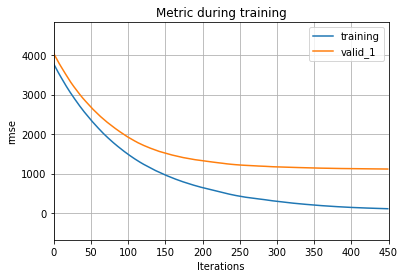

In [16]:
clf = lgb.LGBMRegressor(**hyper_params_gbdt)
clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
lgb.plot_metric(clf)

# Predictions

In [17]:
y_pred_train_gbdt=clf.predict(X_train)
y_pred_val_gbdt=clf.predict(X_val)
y_pred_test_gbdt=clf.predict(X_test)

# Calculating mean_absolute_error

In [18]:
print("mean_absolute_error on training dataset for gbdt= ", mean_absolute_error(y_train, y_pred_train_gbdt))
print("mean_absolute_error on validation dataset for gbdt = ", mean_absolute_error(y_val, y_pred_val_gbdt))
print("mean_absolute_error on test dataset for gbdt = ", mean_absolute_error(y_test, y_pred_test_gbdt))
print("rmse on training dataset for gbdt= ", mean_squared_error(y_train, y_pred_train_gbdt)**0.5)
print("rmse on validation dataset for gbdt = ", mean_squared_error(y_val, y_pred_val_gbdt)**0.5)
print("rmse on test dataset for gbdt = ", mean_squared_error(y_test, y_pred_test_gbdt)**0.5)

mean_absolute_error on training dataset for gbdt=  17.389164174222635
mean_absolute_error on validation dataset for gbdt =  35.630535724255246
mean_absolute_error on test dataset for gbdt =  28.00882286108945
rmse on training dataset for gbdt=  111.28674515906143
rmse on validation dataset for gbdt =  1372.3087514533192
rmse on test dataset for gbdt =  1116.22796127278


# Tuned hyperparameters of LightGBM - rf

In [19]:
hyper_params_rf = {
    'metric': ['mae', 'rmse'],
    'feature_fraction': 0.9,
    'learning_rate': 0.1,
    'boosting_type': 'rf',
    #'early_stopping_rounds':2,
    'bagging_fraction': 0.9,
    'bagging_freq': 30,
    'min_data_in_leaf': 1,
    'verbose': 0,
    "max_depth": 12,
    "num_leaves": 2**12,  
    "max_bin": 1024,
    "num_iterations": 450
}

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] Auto-choosing col-wise multi-threadin

/Users/gsp/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 27.1609	training's rmse: 344.621	valid_1's l1: 49.505	valid_1's rmse: 1620.61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l1: 20.534	training's rmse: 179.56	valid_1's l1: 37.1464	valid_1's rmse: 1294.84
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l1: 18.9226	training's rmse: 150.167	valid_1's l1: 33.39	valid_1's rmse: 1226.77
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	training's l1: 12.8387	training's rmse: 146.922	valid_1's l1: 26.1965	valid_1's rmse: 1116.91
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	training's l1: 12.8014	training's rmse: 146.079	valid_1's l1: 26.1717	valid_1's rmse: 1118.95
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	training's l1: 12.7886	training's rmse: 149.637	valid_1's l1: 26.2522	valid_1's rmse: 1126.56
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	training's l1: 12.6563	training's rmse: 153.513	valid_1's l1: 26.1891	valid_1's rmse: 1134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's l1: 12.6402	training's rmse: 157.075	valid_1's l1: 26.2528	valid_1's rmse: 1141.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	training's l1: 12.5965	training's rmse: 160.587	valid

[93]	training's l1: 13.1704	training's rmse: 197.794	valid_1's l1: 26.5253	valid_1's rmse: 1183.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	training's l1: 13.2136	training's rmse: 198.124	valid_1's l1: 26.554	valid_1's rmse: 1183.95
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	training's l1: 13.2336	training's rmse: 197.94	valid_1's l1: 26.5583	valid_1's rmse: 1184.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	training's l1: 13.1868	training's rmse: 197.856	valid_1's l1: 26.4762	valid_1's rmse: 1183.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	training's l1: 13.1068	training's rmse: 197.862	valid_1's l1: 26.3572	valid_1's rmse: 1181.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	training's l1: 13.1017	training's rmse: 197.89	valid_1's l1: 26.3394	valid_1's rmse: 1171.41
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	training's l1: 13.6399	training's rmse: 218.198	valid_1's l1: 25.8235	valid_1's rmse: 1127.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	training's l1: 13.6412	training's rmse: 218.664	valid_1's l1: 25.8091	valid_1's rmse: 1126.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	training's l1: 13.7581	training's rmse: 220.693	valid_1's l1: 25.9564	valid_1's rmse: 1125.61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	training's l1: 13.7429	training's rmse: 223.267	valid_1's l1: 25.893	valid_1's rmse: 1125.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	training's l1: 13.7107	training's rmse: 223.649	valid_1's l1: 25.8172	valid_1's rmse: 1124.42
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	training's l1: 13.7162	training's rmse: 226.2

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	training's l1: 13.7617	training's rmse: 228.932	valid_1's l1: 25.8658	valid_1's rmse: 1129.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	training's l1: 13.8294	training's rmse: 228.097	valid_1's l1: 25.9108	valid_1's rmse: 1129.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	training's l1: 13.8333	training's rmse: 227.08	valid_1's l1: 25.9267	valid_1's rmse: 1129.68
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	training's l1: 13.8481	training's rmse: 226.415	valid_1's l1: 25.9433	valid_1's rmse: 1130.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	training's l1: 13.8592	training's rmse: 225.483	valid_1's l1: 25.9347	valid_1's rmse: 1129.95
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	training's l1: 13.8703	training's rmse: 224.5

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	training's l1: 13.5534	training's rmse: 191.739	valid_1's l1: 25.8648	valid_1's rmse: 1114.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	training's l1: 13.5177	training's rmse: 191.032	valid_1's l1: 25.8308	valid_1's rmse: 1114.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	training's l1: 13.4877	training's rmse: 190.397	valid_1's l1: 25.8189	valid_1's rmse: 1115.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	training's l1: 13.4919	training's rmse: 189.856	valid_1's l1: 25.8219	valid_1's rmse: 1112.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	training's l1: 13.4653	training's rmse: 189.196	valid_1's l1: 25.7968	valid_1's rmse: 1112.14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	training's l1: 13.4636	training's rmse: 188.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	training's l1: 13.5186	training's rmse: 186.069	valid_1's l1: 26.5121	valid_1's rmse: 1128.97
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	training's l1: 13.5346	training's rmse: 186.4	valid_1's l1: 26.543	valid_1's rmse: 1129.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	training's l1: 13.5449	training's rmse: 186.359	valid_1's l1: 26.5726	valid_1's rmse: 1130.22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	training's l1: 13.5344	training's rmse: 186.496	valid_1's l1: 26.5735	valid_1's rmse: 1130.53
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	training's l1: 13.524	training's rmse: 186.642	valid_1's l1: 26.5745	valid_1's rmse: 1130.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	training's l1: 13.562	training's rmse: 186.809	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	training's l1: 13.5867	training's rmse: 180.226	valid_1's l1: 27.3518	valid_1's rmse: 1150.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	training's l1: 13.5767	training's rmse: 180.007	valid_1's l1: 27.3521	valid_1's rmse: 1151.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	training's l1: 13.5884	training's rmse: 179.75	valid_1's l1: 27.351	valid_1's rmse: 1151.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[332]	training's l1: 13.5604	training's rmse: 179.35	valid_1's l1: 27.3089	valid_1's rmse: 1151.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	training's l1: 13.5697	training's rmse: 179.07	valid_1's l1: 27.3068	valid_1's rmse: 1150.76
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[334]	training's l1: 13.5814	training's rmse: 178.831	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	training's l1: 13.5505	training's rmse: 171.118	valid_1's l1: 27.1572	valid_1's rmse: 1147.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	training's l1: 13.5529	training's rmse: 170.894	valid_1's l1: 27.1877	valid_1's rmse: 1148.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	training's l1: 13.5411	training's rmse: 170.775	valid_1's l1: 27.1772	valid_1's rmse: 1148.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	training's l1: 13.5404	training's rmse: 170.568	valid_1's l1: 27.1774	valid_1's rmse: 1147.61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	training's l1: 13.5454	training's rmse: 170.564	valid_1's l1: 27.1886	valid_1's rmse: 1148.18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	training's l1: 13.5761	training's rmse: 170.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	training's l1: 13.5896	training's rmse: 161.791	valid_1's l1: 27.0467	valid_1's rmse: 1148.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	training's l1: 13.5823	training's rmse: 161.552	valid_1's l1: 27.0333	valid_1's rmse: 1148.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	training's l1: 13.5688	training's rmse: 161.319	valid_1's l1: 27.0062	valid_1's rmse: 1147.39
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	training's l1: 13.5617	training's rmse: 161.092	valid_1's l1: 26.9846	valid_1's rmse: 1146.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	training's l1: 13.5563	training's rmse: 161.016	valid_1's l1: 26.9817	valid_1's rmse: 1145.96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[428]	training's l1: 13.5515	training's rmse: 160.9

/Users/gsp/opt/anaconda3/lib/python3.9/site-packages/lightgbm/plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

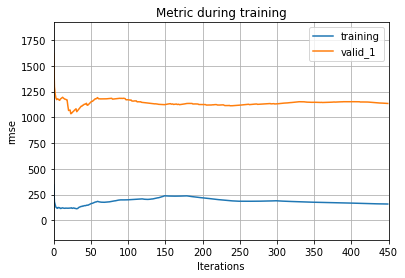

In [20]:
clf = lgb.LGBMRegressor(**hyper_params_rf)
clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
lgb.plot_metric(clf)

In [21]:
y_pred_train_rf=clf.predict(X_train)
y_pred_val_rf=clf.predict(X_val)
y_pred_test_rf=clf.predict(X_test)

In [22]:
print("mean_absolute_error on training dataset for rf= ", mean_absolute_error(y_train, y_pred_train_rf))
print("mean_absolute_error on validation dataset for rf = ", mean_absolute_error(y_val, y_pred_val_rf))
print("mean_absolute_error on test dataset for rf = ", mean_absolute_error(y_test, y_pred_test_rf))
print("rmse on training dataset for rf= ", mean_squared_error(y_train, y_pred_train_rf)**0.5)
print("rmse on validation dataset for rf = ", mean_squared_error(y_val, y_pred_val_rf)**0.5)
print("rmse on test dataset for rf = ", mean_squared_error(y_test, y_pred_test_rf)**0.5)

mean_absolute_error on training dataset for rf=  13.417972599244397
mean_absolute_error on validation dataset for rf =  33.35157301527272
mean_absolute_error on test dataset for rf =  26.738936346702125
rmse on training dataset for rf=  157.67672764709158
rmse on validation dataset for rf =  1385.1323672176713
rmse on test dataset for rf =  1134.6087853285603


# Tuned hyperparameters of LightGBM - goss

In [23]:
hyper_params_goss = {
    'metric': ['mae', 'rmse'],
    'feature_fraction': 0.9,
    'learning_rate': 0.01,
    'boosting_type': 'goss',
    #'early_stopping_rounds':2,
    'min_data_in_leaf': 1,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 2**8,  
    "max_bin": 1024,
    "num_iterations": 450
}

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l1: 516.497	t

/Users/gsp/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l1: 511.655	training's rmse: 3741.37	valid_1's l1: 498.393	valid_1's rmse: 4006.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l1: 506.88	training's rmse: 3705.63	valid_1's l1: 493.769	valid_1's rmse: 3971.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l1: 501.964	training's rmse: 3669.61	valid_1's l1: 489.023	valid_1's rmse: 3936.17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l1: 497.284	training's rmse: 3634.24	valid_1's l1: 484.503	valid_1's rmse: 3901.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's l1: 492.647	training's rmse: 3599.68	valid_1's l1: 479.998	valid_1's rmse: 3867.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's l1: 488.055	training's rmse: 3565.43	valid_1's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	training's l1: 326.106	training's rmse: 2357.94	valid_1's l1: 319.012	valid_1's rmse: 2682.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[52]	training's l1: 323.17	training's rmse: 2336.28	valid_1's l1: 316.209	valid_1's rmse: 2663.81
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[53]	training's l1: 320.461	training's rmse: 2315.44	valid_1's l1: 313.642	valid_1's rmse: 2644.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[54]	training's l1: 317.594	training's rmse: 2294.17	valid_1's l1: 310.891	valid_1's rmse: 2624.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	training's l1: 314.619	training's rmse: 2272.39	valid_1's l1: 308.066	valid_1's rmse: 2606.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	training's l1: 311.796	training's rmse: 2251.54	vali

[101]	training's l1: 207.01	training's rmse: 1488.34	valid_1's l1: 205.272	valid_1's rmse: 1921.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	training's l1: 205.121	training's rmse: 1474.17	valid_1's l1: 203.505	valid_1's rmse: 1910.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	training's l1: 203.246	training's rmse: 1460.26	valid_1's l1: 201.718	valid_1's rmse: 1898.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	training's l1: 201.376	training's rmse: 1446.42	valid_1's l1: 199.95	valid_1's rmse: 1888.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	training's l1: 199.532	training's rmse: 1432.73	valid_1's l1: 198.207	valid_1's rmse: 1878.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	training's l1: 197.735	training's rmse: 1419.97	valid_1's l1: 196.451	valid_1's rmse: 1866.88
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	training's l1: 132.395	training's rmse: 947.583	valid_1's l1: 133.925	valid_1's rmse: 1504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	training's l1: 131.196	training's rmse: 939.078	valid_1's l1: 132.787	valid_1's rmse: 1498.47
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	training's l1: 130.134	training's rmse: 931.626	valid_1's l1: 131.786	valid_1's rmse: 1493.46
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	training's l1: 128.993	training's rmse: 923.067	valid_1's l1: 130.695	valid_1's rmse: 1487.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	training's l1: 127.837	training's rmse: 915.081	valid_1's l1: 129.577	valid_1's rmse: 1481.65
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	training's l1: 126.666	training's rmse: 907.521

[198]	training's l1: 87.2674	training's rmse: 631.832	valid_1's l1: 90.7021	valid_1's rmse: 1301.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	training's l1: 86.5792	training's rmse: 626.65	valid_1's l1: 90.0529	valid_1's rmse: 1298.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	training's l1: 85.8116	training's rmse: 621.374	valid_1's l1: 89.3315	valid_1's rmse: 1295.78
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	training's l1: 85.0522	training's rmse: 616.285	valid_1's l1: 88.6106	valid_1's rmse: 1293.14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	training's l1: 84.3071	training's rmse: 611.261	valid_1's l1: 87.9094	valid_1's rmse: 1290.74
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	training's l1: 83.5809	training's rmse: 606.522	valid_1's l1: 87.2304	valid_1's rmse: 1288.62
[LightGBM] [Warning] No fur

[245]	training's l1: 58.4153	training's rmse: 432.805	valid_1's l1: 63.8023	valid_1's rmse: 1205.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	training's l1: 57.9277	training's rmse: 429.743	valid_1's l1: 63.3538	valid_1's rmse: 1203.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	training's l1: 57.4372	training's rmse: 426.622	valid_1's l1: 62.9037	valid_1's rmse: 1202.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	training's l1: 56.9813	training's rmse: 423.512	valid_1's l1: 62.4905	valid_1's rmse: 1201.31
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	training's l1: 56.5026	training's rmse: 420.704	valid_1's l1: 62.0567	valid_1's rmse: 1200.19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	training's l1: 56.0557	training's rmse: 417.942	valid_1's l1: 61.6543	valid_1's rmse: 1199.06
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	training's l1: 40.1826	training's rmse: 305.892	valid_1's l1: 47.6066	valid_1's rmse: 1160.13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	training's l1: 39.8961	training's rmse: 303.434	valid_1's l1: 47.3707	valid_1's rmse: 1159.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	training's l1: 39.6083	training's rmse: 301.399	valid_1's l1: 47.1085	valid_1's rmse: 1158.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	training's l1: 39.3332	training's rmse: 299.328	valid_1's l1: 46.8732	valid_1's rmse: 1158.18
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	training's l1: 39.0358	training's rmse: 297.44	valid_1's l1: 46.6007	valid_1's rmse: 1157.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	training's l1: 38.7344	training's rmse: 295.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	training's l1: 28.7206	training's rmse: 219.714	valid_1's l1: 37.4558	valid_1's rmse: 1132.61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	training's l1: 28.5378	training's rmse: 218.081	valid_1's l1: 37.3077	valid_1's rmse: 1132.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	training's l1: 28.3358	training's rmse: 216.451	valid_1's l1: 37.1255	valid_1's rmse: 1131.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	training's l1: 28.1362	training's rmse: 214.896	valid_1's l1: 36.9469	valid_1's rmse: 1131.19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	training's l1: 27.9375	training's rmse: 213.305	valid_1's l1: 36.7689	valid_1's rmse: 1130.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	training's l1: 27.7578	training's rmse: 211.9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[393]	training's l1: 20.9909	training's rmse: 153.551	valid_1's l1: 30.8117	valid_1's rmse: 1112.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	training's l1: 20.8836	training's rmse: 152.442	valid_1's l1: 30.7222	valid_1's rmse: 1111.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[395]	training's l1: 20.7729	training's rmse: 151.396	valid_1's l1: 30.6278	valid_1's rmse: 1111.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	training's l1: 20.6885	training's rmse: 150.315	valid_1's l1: 30.5592	valid_1's rmse: 1111.03
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[397]	training's l1: 20.5742	training's rmse: 149.239	valid_1's l1: 30.463	valid_1's rmse: 1110.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	training's l1: 20.4743	training's rmse: 148.1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	training's l1: 16.8302	training's rmse: 112.439	valid_1's l1: 27.3737	valid_1's rmse: 1102.15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	training's l1: 16.7676	training's rmse: 111.768	valid_1's l1: 27.3224	valid_1's rmse: 1101.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[445]	training's l1: 16.7147	training's rmse: 111.169	valid_1's l1: 27.2825	valid_1's rmse: 1101.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[446]	training's l1: 16.6535	training's rmse: 110.585	valid_1's l1: 27.231	valid_1's rmse: 1101.78
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[447]	training's l1: 16.5879	training's rmse: 109.903	valid_1's l1: 27.1762	valid_1's rmse: 1101.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	training's l1: 16.5348	training's rmse: 109.3

/Users/gsp/opt/anaconda3/lib/python3.9/site-packages/lightgbm/plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

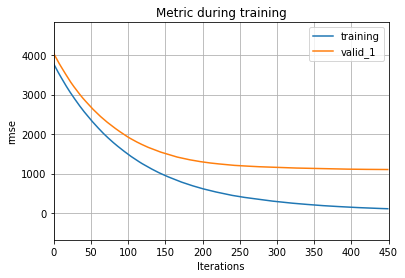

In [24]:
clf = lgb.LGBMRegressor(**hyper_params_goss)
clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])
lgb.plot_metric(clf)

In [25]:
y_pred_train_goss=clf.predict(X_train)
y_pred_val_goss=clf.predict(X_val)
y_pred_test_goss=clf.predict(X_test)

In [26]:
print("mean_absolute_error on training dataset for goss= ", mean_absolute_error(y_train, y_pred_train_goss))
print("mean_absolute_error on validation dataset for goss = ", mean_absolute_error(y_val, y_pred_val_goss))
print("mean_absolute_error on test dataset for goss = ", mean_absolute_error(y_test, y_pred_test_goss))
print("rmse on training dataset for goss= ", mean_squared_error(y_train, y_pred_train_goss)**0.5)
print("rmse on validation dataset for goss = ", mean_squared_error(y_val, y_pred_val_goss)**0.5)
print("rmse on test dataset for goss = ", mean_squared_error(y_test, y_pred_test_goss)**0.5)

mean_absolute_error on training dataset for goss=  16.41662694373102
mean_absolute_error on validation dataset for goss =  34.88339014828041
mean_absolute_error on test dataset for goss =  27.03769670282357
rmse on training dataset for goss=  107.98090293798316
rmse on validation dataset for goss =  1379.6928244182266
rmse on test dataset for goss =  1101.2586624457742
